In [574]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers, Model

from sklearn.utils.class_weight import compute_class_weight

from matplotlib import pyplot as plt

from datetime import datetime

import pickle

from PIL import Image

from custom_class import *

import scipy

print(f"pd.__version__: {pd.__version__}")
print(f"tf.__version__: {tf.__version__}")

image_shape = (120, 160, 3)

pd.__version__: 2.2.3
tf.__version__: 2.15.1


In [575]:
speed_weight_path = "/mnt/c/Users/psamt/OneDrive - The University of Nottingham/_Spring/PHYS4036_Machine Learning in Science Part II/Project/Models/speed_model_20250326_1619/speed_model_20250326_1619.weights.h5"

In [576]:
base_model = keras.applications.MobileNetV3Small(
    include_top=False,
    weights="imagenet",
    input_shape=image_shape,
    pooling=None,
    include_preprocessing=False,
)

feature_extractor = base_model.output

print(feature_extractor.shape)

s_model = []


# model
i = 0

s = feature_extractor

s = layers.Conv2D(32,(3, 3),(2, 2),padding="same",
                  kernel_initializer="he_uniform",name=f"s{i}_conv_1",)(feature_extractor)
s = layers.BatchNormalization(name=f"s{i}_bn_1")(s)
s = layers.Activation("relu", name=f"s{i}_relu_1")(s)
s = layers.GlobalAveragePooling2D(name=f"s{i}_GAP")(s)
# s = layers.Flatten(name=f"s{i}_flatten")(s)

s = layers.Dense(36, activation="relu", kernel_initializer="he_uniform", name=f"s{i}_dense_1")(s)
s = layers.Dropout(0.5, name=f"s{i}_dropout")(s)
s = layers.Dense(3, activation="softmax", name=f"s{i}_output")(s)

s_model.append(s)


outputs_dict = {}

for i in range(len(s_model)):
    outputs_dict[f"speed{i}_output"] = s_model[i]


model = Model(inputs=base_model.input, outputs=outputs_dict, name="speed_model")

model.load_weights(speed_weight_path)


(None, 4, 5, 576)


In [577]:
# model.summary()

In [578]:
# tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [963]:
image_dir = "/mnt/c/Users/psamt/OneDrive - The University of Nottingham/_Spring/PHYS4036_Machine Learning in Science Part II/Project/Captured_data/processed"
image_folder = "eight_red"

label_df = pd.read_csv(os.path.join(image_dir, image_folder, "_labels.csv")).set_index("image_id")

random_index = label_df.sample(n=1).index[0]

image_path = random_index + ".png"
image_full_path = os.path.join(image_dir, image_folder, image_path)

# image_full_path = "/mnt/c/Users/psamt/OneDrive - The University of Nottingham/_Spring/PHYS4036_Machine Learning in Science Part II/Project/Captured_data/1743001154965_90_0.png"

label_df.loc[image_path.split(".")[0]]

img = Image.open(image_full_path).resize((image_shape[1], image_shape[0]))  # Adjust size as per your model
img_array = np.array(img) / 255.0 * 2 - 1
img_array = np.expand_dims(img_array, axis=0)

img_array.shape

preds = model.predict(img_array)

1/1 [==============================] - 0s 23ms/step


In [964]:
pred = preds["speed0_output"][0][0] 
true_label = label_df.loc[image_path.split(".")[0]]['speed']

last_conv_layer = model.get_layer('s0_conv_1')

grad_model = tf.keras.models.Model(
    [model.inputs],
    [last_conv_layer.output, model.output]
)

In [965]:
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(img_array)
    loss = predictions['speed0_output'][0][0]  # First output only

grads = tape.gradient(loss, conv_outputs)[0]
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.07866746187210083..1.0000000298023224].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6..1.0481602138631483].


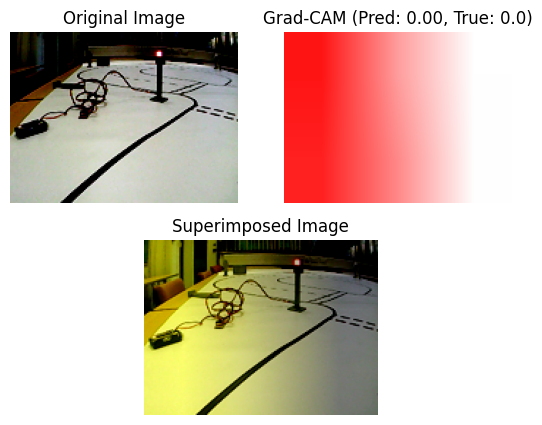

['0.00001', '0.99999', '0.00000']
[0.21194424 0.57611346 0.21194229]


In [966]:
# Generate heatmap
heatmap = tf.reduce_mean(conv_outputs[0] * pooled_grads, axis=-1)
heatmap = np.maximum(heatmap, 0)  # ReLU
heatmap /= np.max(heatmap) + 1e-8  # Normalize

# Resize heatmap
heatmap = Image.fromarray(heatmap).resize((image_shape[1], image_shape[0]), Image.Resampling.BILINEAR)
heatmap = np.array(heatmap)

# Overlay heatmap on original image
original_img = img_array[0]
white_background = np.ones_like(original_img)  # All 1s = white in [0, 1] range
superimposed_img = original_img * 0.6 + heatmap[..., np.newaxis] * [1.0, 1.0, 0.0] * 0.6  # Red heatmap
shaded_img = white_background * (1 - heatmap[..., np.newaxis] * 1.0) + heatmap[..., np.newaxis] * [1.0, 0.0, 0.0] * 1.0
# Visualize
plt.figure(figsize=(10, 5))

# Original image (first row, first column)
plt.subplot(2, 3, 1)  # 2 rows, 3 columns, position 1
plt.imshow(original_img)
plt.title("Original Image")
plt.axis('off')

# Grad-CAM overlay (first row, second column)
plt.subplot(2, 3, 2)  # 2 rows, 3 columns, position 2
plt.imshow(shaded_img)
plt.title(f"Grad-CAM (Pred: {pred:.2f}, True: {true_label})")
plt.axis('off')

# Superimposed image (second row, centered across columns 2-3)
plt.subplot(2, 3, (4, 5))  # 2 rows, 3 columns, spanning positions 5 and 6
plt.imshow(superimposed_img)
plt.title("Superimposed Image")
plt.axis('off')


plt.savefig('gradcam_result.png')
plt.show()
print([f"{s:.5f}" for s in preds["speed0_output"][0]])
print(scipy.special.softmax(preds["speed0_output"][0]))